In [3]:
import os
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats
import nibabel as nib

In [4]:
%matplotlib inline

Organizes data from scan and creates symbolic links in the /data directory of the CNI server


In [5]:
def plot_slice(fname, z_idx=15):

    # Load the image and collect the data
    # and orientation information
    img = nib.load(fname)
    data = img.get_data()
    aff = img.get_affine()

    # Find the center of the brain matrix
    ctr = np.dot(np.linalg.inv(aff), [0, 0, 0, 1])[:3]

    # Plot the data
    vmin, vmax = (0, 1) if data.dtype == np.int16 else (30, 150)
    plt.imshow(np.rot90(data[:, :, ctr[2] + z_idx]), 
               cmap="gray", vmin=vmin, vmax=vmax)
    plt.gca().set_axis_off()

In [6]:
#preliminary stuff
#get subs and make mapping for sub id
data_dir = '/nimsfs/smcclure/fd/'
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'scripts/sub_scan_mappings.txt'
cb_file = home_dir + 'scripts/sub_cb_mappings.txt'

subs = os.listdir(data_dir)
subs = sorted(subs, key= lambda s: int(s.split('_')[2])) #sort subjects by session ID for ease of making text file

#make dictionary mapping scan ids to subject ids
scan_to_id = {}
with open(subj_file) as f:
    for line in f:
        (key,val) = line.strip().split(' ')
        scan_to_id[key] = val

#make dictionary mapping sub ids to counterbalance
sub_to_cb = {}
with open(cb_file) as f:
    for line in f:
        (key,val) = line.strip().split(' ') 
        sub_to_cb[key] = int(val)

#make subject folder if it doesn't exist
for scan in scan_to_id.keys():
    sub_dir = home_dir + 'data/fd_' + scan_to_id[scan]
    if not os.path.isdir(sub_dir):
        os.mkdir(sub_dir)

In [7]:
#short function for getting an ordered list of a directory's contents, sorted by scan number
def get_contents(dir_name):
    sub_files = os.listdir(dir_name)
    sub_files = sorted(sub_files, key = lambda s: int(s.split('_')[1])) 
    return sub_files

In [8]:
#makes a symbolic link if it doesnt exist
def make_link(old_file, new_file):
    if not os.path.isfile(new_file):
#         print new_file
#          cmd_str = 'rm ' + new_file
#          os.system(cmd_str)

         cmd_str = 'ln -s ' + old_file + ' ' + new_file
         os.system(cmd_str)
    return

In [29]:
#create symbolic links for T1s
for scan in scan_to_id.keys():
    sub = scan_to_id[scan]
    
    #create new directory if it doesnt exist
    anat_dir = home_dir + 'data/fd_' + sub + '/anat'
    if not os.path.isdir(anat_dir):
        os.mkdir(anat_dir)
    
    if scan != '20150304_0853_9027': #t1 from a different scan for this subject
    
        #get list of files in directory sorted by scan #
        sub_files = get_contents(data_dir + scan)


        #get T1 directory (anatomical)
        t1 = [f for f in sub_files if f.split('_')[3] == 'T1w'][0]
        
        #append anat file
        old_anat = data_dir + '/' + scan + '/' + t1
        nifti = os.listdir(old_anat)[0]
        old_anat = old_anat + '/' + nifti

        #create symbolic link
        new_anat = anat_dir + '/T1w_Whole_brain_1mm.nii.gz'
        make_link(old_anat,new_anat)


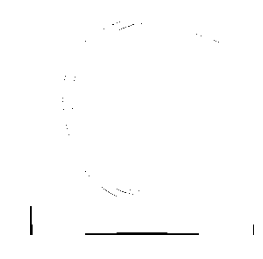

In [30]:
#check one of the subjects files to make sure linking worked
scan = scan_to_id.keys()[0]
sub = scan_to_id[scan]
anat_file = home_dir + 'data/fd_' + sub + '/anat/T1w_Whole_brain_1mm.nii.gz'
plot_slice(anat_file)


In [9]:
#create symbolic links for mux runs
for scan in scan_to_id.keys():
    sub = scan_to_id[scan]
    
    #create new directory if it doesnt exist
    func_dir = home_dir + 'data/fd_' + sub + '/func'
    if not os.path.isdir(func_dir):
        os.mkdir(func_dir)
    new_dir = func_dir + '/ser'
    if not os.path.isdir(new_dir):
        os.mkdir(new_dir)   
    new_dir = func_dir + '/sim'
    if not os.path.isdir(new_dir):
        os.mkdir(new_dir)      
    new_dir = func_dir + '/loc'
    if not os.path.isdir(new_dir):
        os.mkdir(new_dir)  
        
    #get list of files in directory sorted by scan #
    sub_files = get_contents(data_dir + scan)
 
    ##get mux directories (main runs)
    mux = [f for f in sub_files if f.split('_')[4] == '16mm']
    mux = sorted(mux, key = lambda s: int(s.split('_')[1]))
    new_mux = [] ##append list with nifti contained within folder
    for im in mux:
        nifti = os.listdir(data_dir + scan + '/' + im) #filename of nifti contained within folder
        nifti = [f for f in nifti if f.split('.')[1] == 'nii'][0]
        new_mux.append(im + '/' + nifti)
    mux = new_mux
    
    ##toss out mux scans that are too short (aborted scans)
    for im in mux:
        file_path = data_dir + scan + '/' + im
        img = nib.load(file_path)
        
        if img.shape[3] < 40: ##scan less than a minute long
            mux.remove(im)
    
    try:
        ##create symbolic links
        if sub_to_cb[sub] == 1: ##cb 1
            #ser 1
            old_mux = data_dir + scan + '/' + mux[0]
            new_mux = func_dir + '/ser/run_1.nii.gz'
            print os.path.exists(old_mux)
            make_link(old_mux,new_mux)

            #sim 1
            old_mux = data_dir + scan + '/' + mux[1]
            new_mux = func_dir + '/sim/run_1.nii.gz'
            make_link(old_mux,new_mux)

            #ser 2
            old_mux = data_dir + scan + '/' + mux[2]
            new_mux = func_dir + '/ser/run_2.nii.gz'
            make_link(old_mux,new_mux)

            #sim 2
            old_mux = data_dir + scan + '/' + mux[3]
            new_mux = func_dir + '/sim/run_2.nii.gz'
            make_link(old_mux,new_mux)

            #ser 3
            old_mux = data_dir + scan + '/' + mux[4]
            new_mux = func_dir + '/ser/run_3.nii.gz'
            make_link(old_mux,new_mux)

            #sim 3
            old_mux = data_dir + scan + '/' + mux[5]
            new_mux = func_dir + '/sim/run_3.nii.gz'
            make_link(old_mux,new_mux)

            #loc 1
            old_mux = data_dir + scan + '/' + mux[6]
            new_mux = func_dir + '/loc/run_1.nii.gz'
            make_link(old_mux,new_mux)

            #loc 2
            old_mux = data_dir + scan + '/' + mux[7]
            new_mux = func_dir + '/loc/run_2.nii.gz'
            make_link(old_mux,new_mux)

        elif sub_to_cb[sub] == 2: #cb 2
            #ser 1
            old_mux = data_dir + scan + '/' + mux[1]
            new_mux = func_dir + '/ser/run_1.nii.gz'
            make_link(old_mux,new_mux)

            #sim 1
            old_mux = data_dir + scan + '/' + mux[0]
            new_mux = func_dir + '/sim/run_1.nii.gz'
            make_link(old_mux,new_mux)

            #ser 2
            old_mux = data_dir + scan + '/' + mux[3]
            new_mux = func_dir + '/ser/run_2.nii.gz'
            make_link(old_mux,new_mux)

            #sim 2
            old_mux = data_dir + scan + '/' + mux[2]
            new_mux = func_dir + '/sim/run_2.nii.gz'
            make_link(old_mux,new_mux)

            #ser 3
            old_mux = data_dir + scan + '/' + mux[5]
            new_mux = func_dir + '/ser/run_3.nii.gz'
            make_link(old_mux,new_mux)

            #sim 3
            old_mux = data_dir + scan + '/' + mux[4]
            new_mux = func_dir + '/sim/run_3.nii.gz'
            make_link(old_mux,new_mux)

            #loc 1
            old_mux = data_dir + scan + '/' + mux[7]
            new_mux = func_dir + '/loc/run_1.nii.gz'
            make_link(old_mux,new_mux)

            #loc 2
            old_mux = data_dir + scan + '/' + mux[6]
            new_mux = func_dir + '/loc/run_2.nii.gz'
            make_link(old_mux,new_mux)
            
    except Exception:
        pass

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [17]:
##make symbolic links for dti
for scan in scan_to_id.keys():
    sub = scan_to_id[scan]
    
    #create new directory if it doesnt exist
    func_dir = home_dir + 'data/fd_' + sub + '/dti'
    if not os.path.isdir(func_dir):
        os.mkdir(func_dir)
    
    #get list of files in directory sorted by scan #
    sub_files = get_contents(data_dir + scan)

    ##get dti directories
    dti = [f for f in sub_files if f.split('_')[3] == 'DTI']
    dti = sorted(dti, key = lambda s: int(s.split('_')[1]))
    new_dti = [] ##append list with nifti contained within folder
    for im in dti:
        nifti = os.listdir(data_dir + scan + '/' + im) #filename of nifti contained within folder
        nifti = [f for f in nifti if f.split('.')[1] == 'nii'][0]
        new_dti.append(im + '/' + nifti)
    dti = new_dti
    
    #create symbolic links
    for n,im in enumerate(dti):
        old = data_dir + scan + '/' + im
        new = func_dir + '/run_' + str(n + 1) +'.nii.gz'
        make_link(old,new)

In [ ]:

    
    
    
    ##get calibration scans for field map unwarping
    cal2 = [f for f in sub_files if f.split('_')[4] == 'cal2']
    cal2 = sorted(cal2, key = lambda s: int(s.split('_')[1]))
    
    ##need to get just the preceding cal1 scans for field mapping (should be just 4/8)
    cal1 = []
    for cal in cal2:
        preceding_index = int(cal.split('_')[1]) - 1
        c1 = [f for f in sub_files if int(f.split('_')[1]) == preceding_index]
        cal1.append(c1)
    
    
#ln -s /nimsfs/smcclure/efarb/20110506_1157_373/ efarb_sub001